In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import ast

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)

### Loading raw dataset:

In [3]:
df_raw = pd.read_csv('../data/raw/resume_data_1.csv')

### Basic information about the dataset:

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   address                              784 non-null    object 
 1   career_objective                     4740 non-null   object 
 2   skills                               9488 non-null   object 
 3   educational_institution_name         9460 non-null   object 
 4   degree_names                         9460 non-null   object 
 5   passing_years                        9460 non-null   object 
 6   educational_results                  9460 non-null   object 
 7   result_types                         9460 non-null   object 
 8   major_field_of_studies               9460 non-null   object 
 9   professional_company_names           9460 non-null   object 
 10  company_urls                         9460 non-null   object 
 11  start_dates                   

The `matched_score` column could be the target here, as it assess the matching of particular resume with a particular job.

In [5]:
df_raw.head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,company_urls,start_dates,end_dates,related_skils_in_job,positions,locations,responsibilities,extra_curricular_activity_types,extra_curricular_organization_names,extra_curricular_organization_links,role_positions,languages,proficiency_levels,certification_providers,certification_skills,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database warehouse manager with robust experience in handling all kinds of data. I have also used multiple cloud infrastructure services and am well acquainted with ...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', 'C++', 'Data Structures', 'DBMS', 'RDBMS', 'Informa...","['The Amity School of Engineering & Technology (ASET), Noida']",['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],[None],['Nov 2019'],['Till Date'],[['Big Data']],['Big Data Analyst'],['N/A'],Technical Support\nTroubleshooting\nCollaboration\nDocumentation\nSystem Monitoring\nSoftware Deployment\nTraining & Mentorship\nIndustry Trends\nField Visits\n\n\n\n\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a reputed university.,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaboration\nDocumentation\nSystem Monitoring\nSoftware Deployment\nTraining & Mentorship\nIndustry Trends\nField Visits\n\n\n\n\n,NaN,0.850000
1,NaN,Fresher looking to join as a data analyst and junior data scientist. Experienced in creating meaningful data dashboards and evaluation models.,"['Data Analysis', 'Data Analytics', 'Business Analysis', 'R', 'SAS', 'PowerBi', 'Tableau', 'Data Visualization', 'Business Analytics', 'Machine Learning']","['Delhi University - Hansraj College', 'Delhi University - Hansraj College']","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],['N/A'],['Sep 2019'],['Till Date'],"[['Data Analysis', 'Business Analysis', 'Machine Learning']]",['Business Analyst'],['N/A'],Machine Learning Leadership\nCross-Functional Collaboration\nStrategy Development\nML/NLP Infrastructure\nPrototype Transformation\nML System Design\nAlgorithm Research\nApplication Development\nD...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in any relevant discipline from a reputed University,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional Collaboration\nStrategy Development\nML/NLP Infrastructure\nPrototype Transformation\nML System Design\nAlgorithm Research\nApplication Development\nD...,NaN,0.750000
2,NaN,NaN,"['Software Development', 'Machine Learning', 'Deep Learning', 'Risk Assessment', 'Requirement Gathering', 'Application Support', 'JavaScript', 'Python', 'Docker', 'HTML', 'Hive', 'CSS', 'C', 'C++']","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],['N/A'],['June 2018'],['Till Date'],"[['Unified Payment Interface', 'Risk Prediction', 'Big Data', 'Spark', 'PySpark']]",['Software Developer (Machine Learning Engineer)'],['N/A'],"Trade Marketing Executive\nBrand Visibility, Sales Targets\nField Marketing, Campaigns, Product Distribution\nBrand Head\nExcel, KPIs Tracking",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, Hygiene Products",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, Sales Targets\nField Marketing, Campaigns, Product Distribution\nBrand Head\nExcel

### Exploring:

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


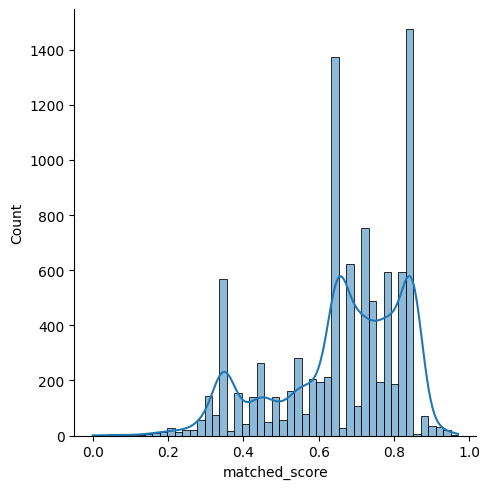

In [6]:
sns.displot(df_raw['matched_score'], kde=True)

We can see that the distribution is a little left skewed.

In [7]:
unique_responsibilities = df_raw['responsibilities.1'].unique()
print(f"There are {len(unique_responsibilities)} unique 'Experience' entries.")
    
    # Display a small random sample to see the different formats
    # Set a seed for reproducibility
np.random.seed(42)    
sample_size = min(15, len(unique_responsibilities)) # Show up to 15 samples
random_sample = np.random.choice(unique_responsibilities, size=sample_size, replace=False)
    
print(f"\nHere is a random sample of {sample_size} unique 'Experience' values:")
for i, exp in enumerate(random_sample):
    print(f"{i+1:2d}. {exp}")

There are 28 unique 'Experience' entries.

Here is a random sample of 15 unique 'Experience' values:
 1. Database Design & Development
SQL Query Optimization
Data Integrity & Security
BI Solutions Development
ETL Process Implementation
Database Maintenance
Backup & Restore Management
Index Rebuilding & Performance Tuning
SQL Server Clustering & High Availability
SQL Server Replication
High Availability Group Management
Database Monitoring & Troubleshooting
 2. Recruitment Coordination
Appointment Management
Selection Criteria
Employee Orientation
Performance Evaluation
HR Database Management
Report Compilation
Documentation
Event Coordination
Task Execution
 3. Administrative Support
Scheduling
Filing & Documentation
Communication
Team Support
Equipment Maintenance
Information Provision
Inventory Management
Team Collaboration
OHS Policy Development
Safety Advice
Risk Assessment
Policy Review
OHS Training
Safety Inspections
Unsafe Act Prevention
Incident Investigation
Report Preparation

### A function to extract number of years of experience from resume profiles:

In [8]:
def extract_experience_years(text):
    if isinstance(text, str):
        text = text.lower()
        
        # Case 1: Range like "5 to 8 years" or "5-10 years" -> take the first number
        range_match = re.search(r'(\d+)\s*(to|-)\s*\d+', text)
        if range_match:
            return int(range_match.group(1))
            
        # Case 2: Number followed by "year" or "years" e.g., "At least 1 year"
        year_match = re.findall(r'(\d+)\s*year', text)
        if year_match:
            return int(year_match[0])
            
        # Case 3: Just a number
        num_match = re.findall(r'\d+', text)
        if num_match:
            return int(num_match[0])

    # Case 4: If no numbers are found or if the input is not a string (like nan)
    return 0 # Default to 0 for 'Fresher' or missing values


In [9]:
print(extract_experience_years('Need experience of more than 3 years'))

3


### Creating a new col `experience_years_required` that will contain number of years of experience required for that job position:

In [10]:
df_raw['experience_years_required'] = df_raw['experiencere_requirement'].apply(extract_experience_years)

In [11]:
df_raw['experience_years_required'].head()

0    1
1    5
2    3
3    1
4    4
Name: experience_years_required, dtype: int64

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


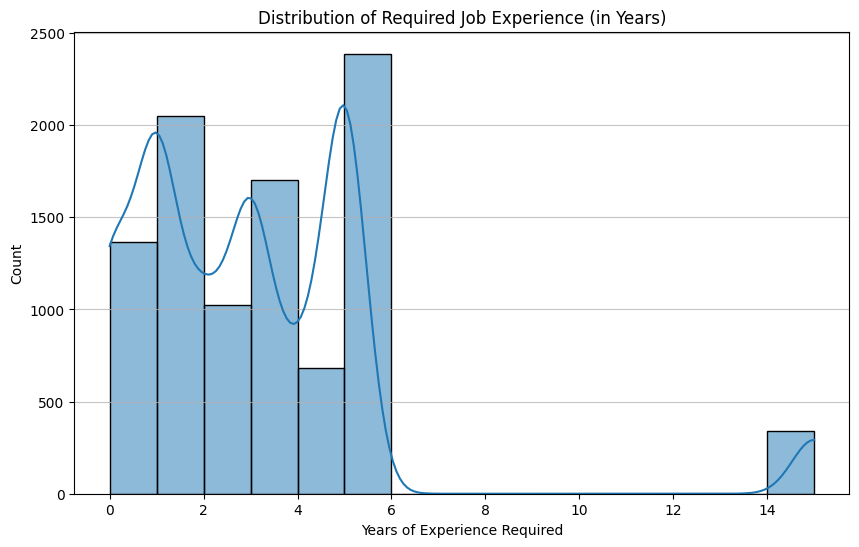

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df_raw['experience_years_required'], bins=15, kde=True)
plt.title('Distribution of Required Job Experience (in Years)')
plt.xlabel('Years of Experience Required')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

We can see that there's an outlier of 14-15 years of experience required. However, except that the normal range of experience required in betwee 0 and 6.<br>Also, we can see that the most common is 5 years of experience.

Let's see which jobs are asking for 1 years of experience:

In [13]:
df_raw[df_raw['experience_years_required'] == 15].head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,company_urls,start_dates,end_dates,related_skils_in_job,positions,locations,responsibilities,extra_curricular_activity_types,extra_curricular_organization_names,extra_curricular_organization_links,role_positions,languages,proficiency_levels,certification_providers,certification_skills,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score,experience_years_required
42,NaN,"To design, develop and manage products in the field of consumer electronics devices, networking protocols, internet applications and connected devices. Vision to create personalized experiences ba...","['Lead Development', 'build teams', 'mentor', 'interface with customers and vendors', 'architect end to end', 'Develop products in consumer electronics', 'digital TV', 'industrial automation', 'co...","['Indian Institute of Technology', 'Devi Ahilya University', 'Coursera - Stanford']","['M.Tech', 'B.E', 'Course']","['1988', '87', '2016']","['N/A', 'N/A', 'N/A']","['N/A', 'N/A', 'N/A']","['Control Systems', 'Electrical Engineering', 'Machine learning']","['Company Name', 'Company Name', 'Company Name']","[None, None, None]","['November 2010', 'January 2004', 'April 2000']","['May 2016', 'November 2010', 'January 2004']","[['platform software development', 'middleware solution', 'JSON APIs'], ['consumer electronics', 'BD-J stack', 'OCAP middleware', 'embedded systems'], ['interactive TV', 'set-top boxes', 'Java bas...","['Engineering Manager', 'Engineering Manager, Architect', 'Senior Software Engineer']","['City , State', 'City , State', 'City , State']",15+ Years Banking Experience\nAudit/Inspection/ICC Leadership\nInternal Audit & Compliance\nRisk-Based Operational Reviews\nSystem-Based Audit Expertise\nKnowledge of Bangladeshi Laws,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Head of Internal Control & Compliance (ICC) - SEVP/DMD,"Masters, Master of Business Administration (MBA), Master of Business Management (MBM)",At least 15 years,Age at most 52 years,15+ Years Banking Experience\nAudit/Inspection/ICC Leadership\nInternal Audit & Compliance\nRisk-Based Operational Reviews\nSystem-Based Audit Expertise\nKnowledge of Bangladeshi Laws,AUDIT AND INSPECTION\nBanking\nInternal Audit,0.550000,15
86,NaN,"A versatile and dynamic manager and marketing professional with more than (20) years of sales, management, marketing and promotional experience. A goal oriented and trusted leader, able to communi...","['Seasoned Leadership', 'Experienced Manager', 'Motivated', 'Balanced']",['Stephen F. Austin State University'],['Bachelor of Arts Degree'],[None],"[""Dean's List recognition""]",[None],['Communications'],"['Company Name', 'Company Name', 'Company Name', 'Company Name', 'Company Name']","[None, None, None, None, None]","['11/2011', '06/2009', '05/2002', '05/1998', '02/1992']","['05/2014', '10/2011', '06/2009', '05/2002', '05/1998']","[None, None, None, None, None]","['Partner; Business Development', 'Regional Manager; Consumer Engagement', 'Regional Event Marketing Manager', 'One-on-One Marketing Supervisor', 'Sales Representative']","['City , State', 'City , State', 'City , State', 'City , State', 'City , State']",15+ Years Banking Experience\nAudit/Inspection/ICC Leadership\nInternal Audit & Compliance\nRisk-Based Operational Reviews\nSystem-Based Audit Expertise\nKnowledge of Bangladeshi Laws,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Head of Internal Control & Compliance (ICC) - SEVP/DMD,"Masters, Master of Business Administration (MBA), Master of Business Management (MBM)",At least 15 years,Age at most 52 years,15+ Years Banking Experience\nAudit/Inspection/ICC Leadership\nInternal Audit & Compliance\nRisk-Based Operational Reviews\nSystem-Based Audit Expertise\nKnowledge of B

We can see that these are all the same job position - Audit and Inspection of a Bank i guess.

### Exploring skills in resumes and jobs:

In [14]:
def process_skills_text(series):
    # Drop NaNs and convert to a single string
    all_skills_text = series.dropna().str.cat(sep=' ')
    
    # Clean the text: remove list-like characters and extra quotes
    all_skills_text = re.sub(r"[\[\]',]", "", all_skills_text)
    
    # Convert to lowercase
    return all_skills_text.lower()

#### Funciton to plot a word cloud:

In [15]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=50,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()


Generating Word Cloud for Resume Skills...


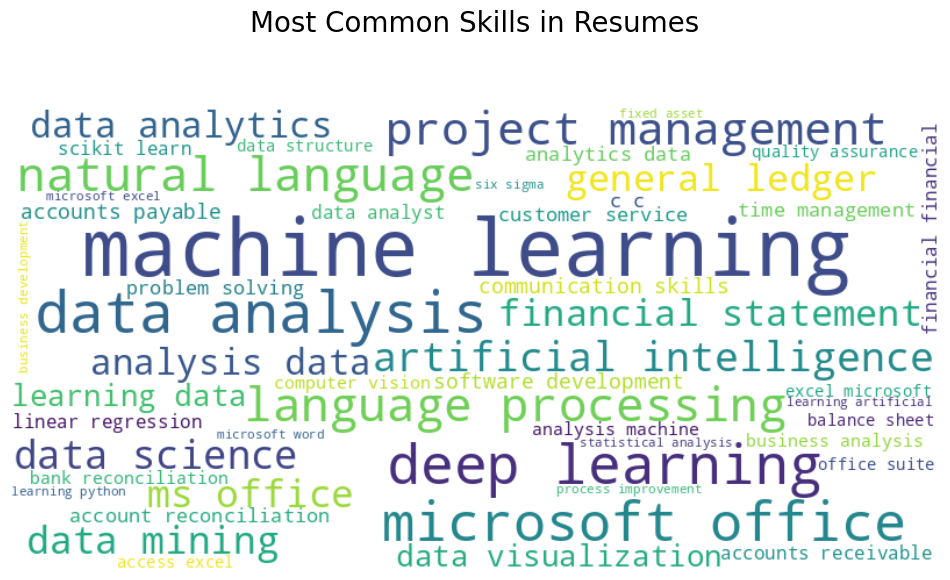

In [16]:
resume_skills_text = process_skills_text(df_raw['skills'])
print("\nGenerating Word Cloud for Resume Skills...")
plot_wordcloud(resume_skills_text, "Most Common Skills in Resumes\n\n")

From this word cloud, we can see that most resumes include skills related to data science and machine learning.


Generating Word Cloud for Job Skills...


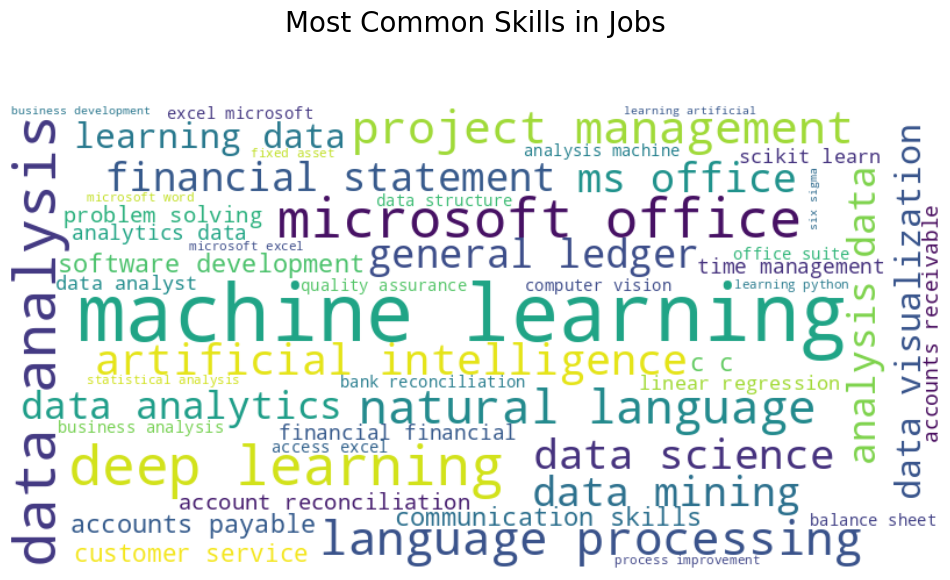

In [17]:
job_skills_text = process_skills_text(df_raw['skills_required'])
print("\nGenerating Word Cloud for Job Skills...")
plot_wordcloud(resume_skills_text, "Most Common Skills in Jobs\n\n")

Even in job requirements, it seems like machine learning and data science related skills are dominating. 

### It seems that the skills in resumes and the required skills in jobs are very similar.

#### Trying to quantify this similarity in skills:

In [18]:
def calculate_skill_overlap(row):
    try:
        # Clean and split resume skills into a set
        resume_skills = set(re.sub(r"[\[\]',]", "", row['skills']).lower().split())
        
        # Clean and split job skills into a set
        job_skills = set(re.sub(r"[\[\]',]", "", row['skills_required']).lower().split())

        # Find the intersection (common skills)
        intersection = resume_skills.intersection(job_skills)
        
        # Find the union
        union = resume_skills.union(job_skills)
        
        # Calculate Jaccard similarity
        jaccard_score = len(intersection) / len(union) if len(union) > 0 else 0
        
        return pd.Series([len(intersection), jaccard_score])
    except:
        # Return 0 if there's an error (e.g., NaN values)
        return pd.Series([0, 0.0])


In [19]:
df_raw[df_raw['matched_score'] == max(df_raw['matched_score'])]

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,company_urls,start_dates,end_dates,related_skils_in_job,positions,locations,responsibilities,extra_curricular_activity_types,extra_curricular_organization_names,extra_curricular_organization_links,role_positions,languages,proficiency_levels,certification_providers,certification_skills,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score,experience_years_required
5581,NaN,NaN,"['Technical Support', 'Telecom Support', 'Networking Support', 'Software/PC/LAN Troubleshooting', 'Installing, Configuring, Troubleshooting Windows, Linux and OS X', 'Installing, Configuring, Trou...",NaN,NaN,NaN,NaN,NaN,NaN,"['Company Name', 'Company Name']","[None, None]","['01/2015', '06/2012']","['Current', '08/2014']","[['Remote Support', 'Troubleshooting', 'Platform Support', 'Software Installation', 'Account Management', 'Collaboration'], ['Remote Support', 'Software Installation', 'Troubleshooting', 'Security...","['Corporate Engineering Support Technician', 'Help Desk Support Analyst II']","['City , State', 'City , State']",Mikrotik Router Configuration\nOLT Device Setup & Management\nIntegration with Billing Software\nNetwork Monitoring Tools Integration\nConnectivity Troubleshooting\nTechnical Support & Escalation\...,NaN,NaN,NaN,NaN,NaN,NaN,['CBTNuggets.com'],"[['System Administration', 'Windows Server', 'Networking', 'Security', 'System Management']]",[None],['N/A'],[None],Network Support Engineer,"Diploma, Bachelor/Honors",At least 3 years,Age 25 to 35 years,Mikrotik Router Configuration\nOLT Device Setup & Management\nIntegration with Billing Software\nNetwork Monitoring Tools Integration\nConnectivity Troubleshooting\nTechnical Support & Escalation\...,CCNA (Cisco Certified Network Associate)\nGPON\nHardware & Networking\nIIG\nISP\nIT Enabled services\nOLT and ONU,0.97,3


In [20]:
calculate_skill_overlap(df_raw.iloc[5581, :])

0    7.00000
1    0.03271
dtype: float64

### Now, creating new cols to hold skill overlap count (meaning the number of skills that are present in both the resumes and the job requirements), and a jaccard score of this similarity.

#### `We are using Jaccard because it fits best with the case here, as we are comparing the skills that are common in both resumes and jobs.`

Created 'Skill_Overlap_Count' and 'Skill_Jaccard_Score' features.

Verification of skill overlap features:
                                                                                                                                                                                                    skills  \
0  ['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', 'C++', 'Data Structures', 'DBMS', 'RDBMS', 'Informa...   
1                                               ['Data Analysis', 'Data Analytics', 'Business Analysis', 'R', 'SAS', 'PowerBi', 'Tableau', 'Data Visualization', 'Business Analytics', 'Machine Learning']   
2    ['Software Development', 'Machine Learning', 'Deep Learning', 'Risk Assessment', 'Requirement Gathering', 'Application Support', 'JavaScript', 'Python', 'Docker', 'HTML', 'Hive', 'CSS', 'C', 'C++']   
3  ['accounts payables', 'accounts receivables', 'Accounts Payable', 

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


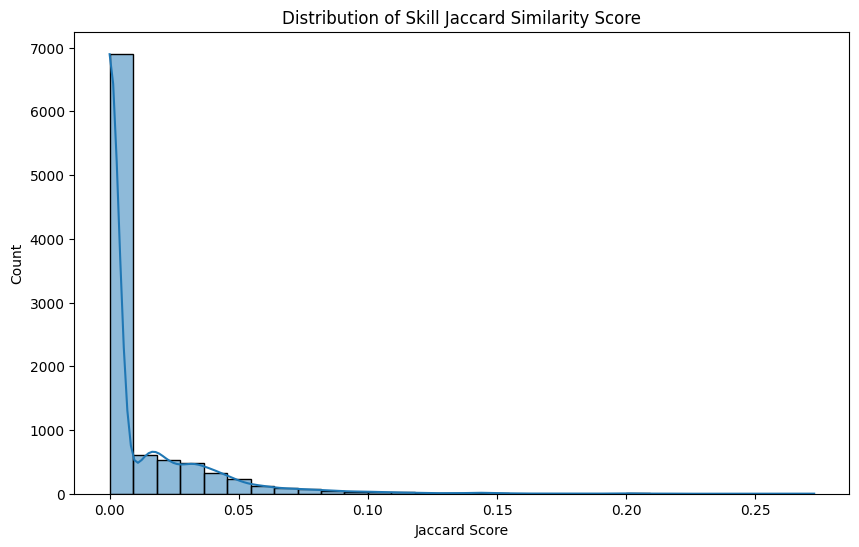

In [21]:
df_raw[['Skill_Overlap_Count', 'Skill_Jaccard_Score']] = df_raw.apply(calculate_skill_overlap, axis=1)
    
print("Created 'Skill_Overlap_Count' and 'Skill_Jaccard_Score' features.")
print("\nVerification of skill overlap features:")
print(df_raw[['skills', 'skills_required', 'Skill_Overlap_Count', 'Skill_Jaccard_Score']].head(10))
    
# Let's see the distribution of the Jaccard score
plt.figure(figsize=(10, 6))
sns.histplot(df_raw['Skill_Jaccard_Score'], bins=30, kde=True)
plt.title('Distribution of Skill Jaccard Similarity Score')
plt.xlabel('Jaccard Score')
plt.ylabel('Count')
plt.show()

We can see that the jaccard score is highly right skewed, and the most values are zeros, meaning that in most of the jobs and resumes, we don't actually see a high similarity.

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


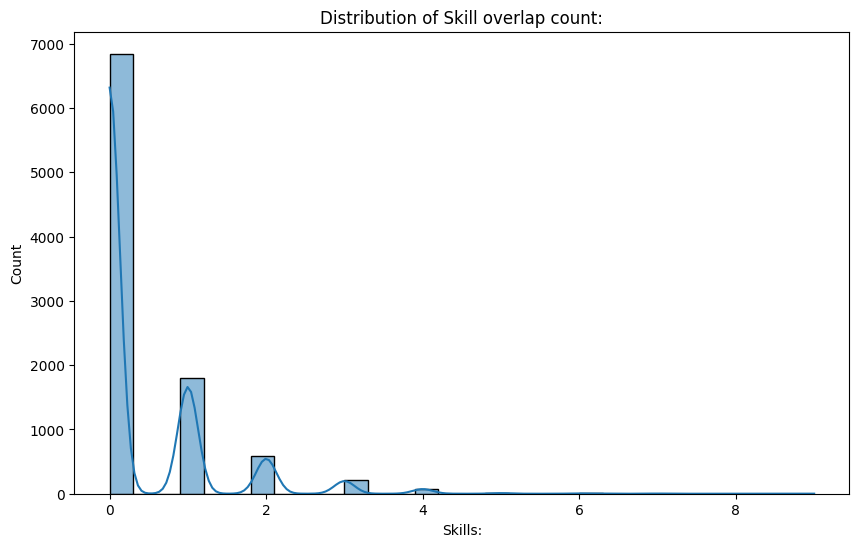

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df_raw['Skill_Overlap_Count'], bins=30, kde=True)
plt.title('Distribution of Skill overlap count:')
plt.xlabel('Skills:')
plt.ylabel('Count')
plt.show()

Most resumes and jobs dont overlap the skills either.

In [23]:
df_raw['matched_score'].describe()

count    9544.000000
mean        0.660831
std         0.167040
min         0.000000
25%         0.583333
50%         0.683333
75%         0.793333
max         0.970000
Name: matched_score, dtype: float64

Trying to extract experience years from the resumes:

In [24]:
df_raw[['professional_company_names', 'start_dates', 'end_dates', 'positions']]

,professional_company_names,start_dates,end_dates,positions
0,['Coca-COla'],['Nov 2019'],['Till Date'],['Big Data Analyst']
1,['BIB Consultancy'],['Sep 2019'],['Till Date'],['Business Analyst']
2,['Axis Bank Limited'],['June 2018'],['Till Date'],['Software Developer (Machine Learning Engineer)']
3,"['Company Name ï¼ City , State', 'Company Name ï¼ City , State', 'Company Name ï¼ City , State', 'Company Name ï¼ City , State', 'Company Name ï¼ City , State', 'N/A']","['January 2011', 'January 2008', 'January 2006', 'January 2004', 'January 2001', 'N/A']","['November 2015', 'January 2010', 'January 2008', 'January 2006', 'January 2004', None]","['Accountant', 'Accounts Receivable Clerk', 'Mortgage Underwriter', 'Commercial Auto Underwriter', 'Personal Auto Underwriter', 'Claims Examiner']"
4,"['Company Name', 'Company Name', 'Company Name', 'Company Name', 'Company Name']","['January 2016', 'January 2016', 'January 2012', 'January 2009', 'January 2006']","['Current', 'January 2016', 'January 2015', 'January 2011', 'January 2009']","['Staff Accountant', 'Senior Accountant', 'Tax Analyst', 'Staff Accountant II', 'Staff Auditor II']"
...,...,...,...,...
9539,['BPM Foundation'],['Jun 2020'],['Ongoing'],['Data Manager']
9540,['Passionate Solution'],['Feb 2020'],['Ongoing'],['Jr. Data Scientist']
9541,['ZigSAW'],['Apr 2019'],['Dec 2020'],['SDE and Business Analyst Trainee']
9542,['Zynta Labs'],['Apr 2019'],['Nov 2019'],['NLP Developer Intern']


There are the 4 most important cols to extract experience from the resume, as we have start and end dates in each resume as well as the company names, so it becomes logical to extract experience from them.

In [25]:
def calculate_resume_experience_from_lists(row):
    try:
        # These are the columns from your screenshot
        company_str = row['professional_company_names']
        starts_str = row['start_dates']
        ends_str = row['end_dates']
        
        # Safely parse the strings into actual Python lists
        companies = ast.literal_eval(company_str)
        start_dates = ast.literal_eval(starts_str)
        end_dates = ast.literal_eval(ends_str)
        
        # Ensure lists are of the same length to avoid errors
        if not (len(companies) == len(start_dates) == len(end_dates)):
            return 0

        total_exp = 0
        current_year = 2025 # Use a consistent current year

        # Loop through each job listed in the resume
        for i in range(len(companies)):
            start_str = str(start_dates[i])
            end_str = str(end_dates[i])
            
            # Extract year from start date string
            start_year_match = re.search(r'(\d{4})', start_str)
            start_year = int(start_year_match.group(1)) if start_year_match else 0
            
            # Extract year from end date string, handling 'Ongoing' cases
            end_year = current_year # Default to current year
            if 'ongoing' in end_str.lower() or 'till date' in end_str.lower() or 'current' in end_str.lower():
                end_year = current_year
            else:
                end_year_match = re.search(r'(\d{4})', end_str)
                if end_year_match:
                    end_year = int(end_year_match.group(1))

            # Add to total if we have a valid start year
            if start_year > 0:
                duration = end_year - start_year
                if duration >= 0: # Add only non-negative durations
                    total_exp += duration
                    
        return total_exp
    except (ValueError, SyntaxError, TypeError, IndexError):
        # Gracefully handle rows with malformed data
        print("\nSome error in extracting experiences from resume........\n")
        return 0

In [26]:
test_exp = calculate_resume_experience_from_lists(df_raw.iloc[0, :])
print(test_exp)

6


We can see that in row 0, the start date is 2019 and the end date mentions till date, meaning that the job is ongoing and thus, we have taken 2025 as the default end date. And we get 6 years of experience which is correct.

Now, let's create 2 new cols, one about experience and the other about the mismatch of experience between what the company is asking for and the experience each user has in their resume:

In [27]:
df_raw.columns

Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results', 'result_types',
       'major_field_of_studies', 'professional_company_names', 'company_urls',
       'start_dates', 'end_dates', 'related_skils_in_job', 'positions',
       'locations', 'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names',
       'extra_curricular_organization_links', 'role_positions', 'languages',
       'proficiency_levels', 'certification_providers', 'certification_skills',
       'online_links', 'issue_dates', 'expiry_dates', '﻿job_position_name',
       'educationaL_requirements', 'experiencere_requirement',
       'age_requirement', 'responsibilities.1', 'skills_required',
       'matched_score', 'experience_years_required', 'Skill_Overlap_Count',
       'Skill_Jaccard_Score'],
      dtype='object')

In [28]:
print("Applying function to calculate resume experience...")

# Create the new 'Resume_Years_Exp' feature
df_raw['Resume_Years_Exp'] = df_raw.apply(calculate_resume_experience_from_lists, axis=1)
    
# Finally, create the mismatch feature
df_raw['Experience_Mismatch'] = abs(df_raw['Resume_Years_Exp'] - df_raw['experience_years_required'])
    
print("\nSuccessfully created 'Resume_Years_Exp' and 'Experience_Mismatch' features.")

Applying function to calculate resume experience...

Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Some error in extracting experiences from resume........


Som

Although, some columns couldn't be extracted, most of them were, and now we have some additional informative cols to help in our predictions.

### Cleaning Degree Names:

In [30]:
print("\n--- Engineering Structured Features from 'degree_names' ---")

def process_degree_data(degree_string):
    """
    Parses the complex 'degree_names' string to extract the highest education level
    and the general type of degree (STEM, Business, Arts, Other).
    """
    # Define keywords for different levels and types
    master_keywords = ['master', 'm.sc', 'msc', 'm.a', 'mba', 'm.com']
    bachelor_keywords = ['bachelor', 'b.sc', 'bsc', 'b.tech', 'bba', 'b.a', 'b.com']
    doctorate_keywords = ['ph.d', 'phd', 'doctorate']
    
    stem_keywords = ['science', 'tech', 'eng', 'computer', 'math', 'statistic']
    business_keywords = ['business', 'bba', 'mba', 'account', 'financ', 'commerc']
    arts_keywords = ['arts', 'humanities']

    highest_level = 'Other'
    degree_type = 'Other'
    
    try:
        # Safely evaluate the string to a list, handling NaNs
        degrees = ast.literal_eval(str(degree_string))
        
        # Make it a list if it's not one
        if not isinstance(degrees, list):
            degrees = [degrees]
            
        found_levels = []
        found_types = []

        for degree in degrees:
            degree_lower = str(degree).lower()
            
            # Check for education level
            if any(keyword in degree_lower for keyword in doctorate_keywords):
                found_levels.append(3) # 3 for Doctorate
            elif any(keyword in degree_lower for keyword in master_keywords):
                found_levels.append(2) # 2 for Master
            elif any(keyword in degree_lower for keyword in bachelor_keywords):
                found_levels.append(1) # 1 for Bachelor
            
            # Check for degree type
            if any(keyword in degree_lower for keyword in stem_keywords):
                found_types.append('STEM')
            elif any(keyword in degree_lower for keyword in business_keywords):
                found_types.append('Business')
            elif any(keyword in degree_lower for keyword in arts_keywords):
                found_types.append('Arts')

        # Determine the highest level achieved
        if found_levels:
            max_level = max(found_levels)
            if max_level == 3: highest_level = 'Doctorate'
            elif max_level == 2: highest_level = 'Masters'
            elif max_level == 1: highest_level = 'Bachelors'
        
        # Determine the primary degree type (prioritize STEM > Business > Arts)
        if 'STEM' in found_types: degree_type = 'STEM'
        elif 'Business' in found_types: degree_type = 'Business'
        elif 'Arts' in found_types: degree_type = 'Arts'
            
    except (ValueError, SyntaxError):
        # Handle cases where the string is not a valid list
        pass

    return pd.Series([highest_level, degree_type])


--- Engineering Structured Features from 'degree_names' ---


In [31]:
df_raw[['highest_education_level', 'degree_type']] = df_raw['degree_names'].apply(process_degree_data)
print("Created 'highest_education_level' and 'degree_type' features.")
    
# Verification: Display original vs. new columns
print("\nVerification of new education features:")
display_cols = ['degree_names', 'highest_education_level', 'degree_type']
display(df_raw[display_cols].head())

print("\nDistribution of new features:")
print(df_raw['highest_education_level'].value_counts())
print("\n")
print(df_raw['degree_type'].value_counts())

Created 'highest_education_level' and 'degree_type' features.

Verification of new education features:


,degree_names,highest_education_level,degree_type
0,['B.Tech'],Bachelors,STEM
1,"['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']",Masters,STEM
2,['B.Tech'],Bachelors,STEM
3,['Computer Applications Specialist Certificate Program'],Other,STEM
4,['Bachelor of Business Administration'],Bachelors,Business



Distribution of new features:
highest_education_level
Bachelors    5228
Other        2228
Masters      1920
Doctorate     168
Name: count, dtype: int64


degree_type
STEM        6252
Other       2386
Business     672
Arts         234
Name: count, dtype: int64


In [32]:
df_raw.head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,company_urls,start_dates,end_dates,related_skils_in_job,positions,locations,responsibilities,extra_curricular_activity_types,extra_curricular_organization_names,extra_curricular_organization_links,role_positions,languages,proficiency_levels,certification_providers,certification_skills,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score,experience_years_required,Skill_Overlap_Count,Skill_Jaccard_Score,Resume_Years_Exp,Experience_Mismatch,highest_education_level,degree_type
0,NaN,Big data analytics working and database warehouse manager with robust experience in handling all kinds of data. I have also used multiple cloud infrastructure services and am well acquainted with ...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', 'C++', 'Data Structures', 'DBMS', 'RDBMS', 'Informa...","['The Amity School of Engineering & Technology (ASET), Noida']",['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],[None],['Nov 2019'],['Till Date'],[['Big Data']],['Big Data Analyst'],['N/A'],Technical Support\nTroubleshooting\nCollaboration\nDocumentation\nSystem Monitoring\nSoftware Deployment\nTraining & Mentorship\nIndustry Trends\nField Visits\n\n\n\n\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a reputed university.,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaboration\nDocumentation\nSystem Monitoring\nSoftware Deployment\nTraining & Mentorship\nIndustry Trends\nField Visits\n\n\n\n\n,NaN,0.850000,1,0.0,0.0,6,5,Bachelors,STEM
1,NaN,Fresher looking to join as a data analyst and junior data scientist. Experienced in creating meaningful data dashboards and evaluation models.,"['Data Analysis', 'Data Analytics', 'Business Analysis', 'R', 'SAS', 'PowerBi', 'Tableau', 'Data Visualization', 'Business Analytics', 'Machine Learning']","['Delhi University - Hansraj College', 'Delhi University - Hansraj College']","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],['N/A'],['Sep 2019'],['Till Date'],"[['Data Analysis', 'Business Analysis', 'Machine Learning']]",['Business Analyst'],['N/A'],Machine Learning Leadership\nCross-Functional Collaboration\nStrategy Development\nML/NLP Infrastructure\nPrototype Transformation\nML System Design\nAlgorithm Research\nApplication Development\nD...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in any relevant discipline from a reputed University,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional Collaboration\nStrategy Development\nML/NLP Infrastructure\nPrototype Transformation\nML System Design\nAlgorithm Research\nApplication Development\nD...,NaN,0.750000,5,0.0,0.0,6,1,Masters,STEM
2,NaN,NaN,"['Software Development', 'Machine Learning', 'Deep Learning', 'Risk Assessment', 'Requirement Gathering', 'Application Support', 'JavaScript', 'Python', 'Docker', 'HTML', 'Hive', 'CSS', 'C', 'C++']","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],['N/A'],['June 2018'],['Till Date'],"[['Unified Payment Interface', 'Risk Prediction', 'Big Data', 'Spark', 'PySpark']]",['Software Developer (Machine Learning Engineer)'],['N/A'],"Trade Marketing Executive\nBrand Visibility, Sales Targets\nField Marketing, Campaigns, Product Distribution\nBrand Head\nExcel, KPIs Tracking",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, Hygiene Prod

### Saving this dataset for further use:

In [33]:
df_raw.to_csv('../data/processed/refined_df.csv', index=False)